In [1]:
from astropy import units as u
import numpy as np
import pylab as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import matplotlib
from astropy.cosmology import LambdaCDM
  
from tools.Predictions import f_lim, ChannelVelocitywidth, Observed_freq, OHflux, OHpeakflux


cosmos = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)


sns.set_style("whitegrid")



params = {'legend.fontsize': 12,
          'axes.labelsize': 15,
          'axes.titlesize': 15,
          'axes.linewidth': 0.5,
          'axes.edgecolor': '.15',
          'xtick.labelsize' :15,
          'ytick.labelsize': 15,
          'mathtext.fontset': 'cm',
          'mathtext.rm': 'serif',
          'mathtext.bf': 'serif:bold',
          'mathtext.it': 'serif:italic',
          'mathtext.sf': 'sans\\-serif',
         }
matplotlib.rcParams.update(params)

plt.rcParams["mathtext.default"] = "regular"

MeerKAT SEFD plots:

Text(0, 0.5, 'SEFD[Jy]')

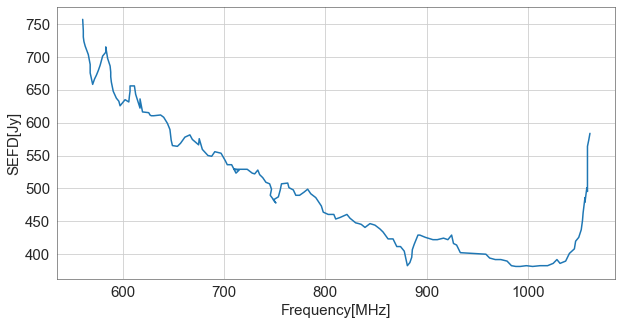

In [2]:
SEFD_UHF = pd.read_csv('tools/MeerKAT_UHF-band.csv')
SEFD_UHF.head()

plt.figure(figsize=(10,5))
plt.plot(SEFD_UHF['Frequency_MHz'], SEFD_UHF['SEFD_Jy'])
plt.xlabel('Frequency[MHz]')
plt.ylabel('SEFD[Jy]')

In [3]:
def sefd_interp(obs_freq, xp = SEFD_UHF['Frequency_MHz'].values, fp = SEFD_UHF['SEFD_Jy'].values):
    return np.interp(obs_freq, xp, fp)
    
sefd_interp(900)

425.07267441860466

Now can we find the SEFD at a given redshifted frequency given the redshift of the source

# MeerKAT's capability to detect OH plots

OH detectability plot:

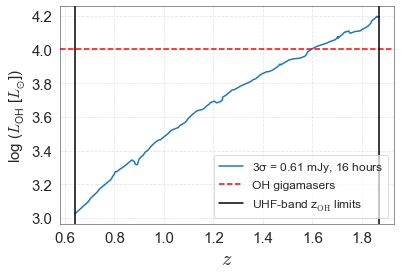

In [4]:
z_OH = np.arange(0.64, 1.87, 1e-6)

obs_freq = Observed_freq(z_OH, restfreq=1667.35899).value
BW = ChannelVelocitywidth(f_obs=obs_freq, Totalbandwidth=544, correlator='32k')[0].value

L_min, S_min = f_lim(z_OH, SEFD=sefd_interp(obs_freq), Ncorr=1, Npol=2,
                     Nant=58, time_int=16, bandwidth=BW, sigma_level=3,
                     restV=150, restfreq=1667.35899)


# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(z_OH, L_min, color='tab:blue', label='3$\sigma$ = %.2f mJy, 16 hours' % (np.median(S_min.value) * 1e3))
ax.axhline(4, xmin=0, xmax=z_OH.max(), linestyle='dashed', color='red', label='OH gigamasers')
ax.axvline(1.87, ymin=0, ymax=L_min.max(), linestyle='solid', color='black', label=r'UHF-band $z_{\rm OH}$ limits')
ax.axvline(0.64, ymin=0, ymax=L_min.max(), linestyle='solid', color='black')

# Set axis labels with improved font settings
ax.set_xlabel(r'$\mathit{z}$', fontsize=20)
ax.set_ylabel(r'log ($\mathit{L}_{OH}$ [$\mathit{L}_{\odot}$])')

# Add legend with improved settings
ax.legend(fontsize=12,frameon=True, framealpha=0.7)

# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Save the plot with high resolution
plt.savefig('ThisWork_LOHvs_redshift.png', dpi=500, bbox_inches='tight')

# Show plot
plt.show()


OH detectability plot with real data:

In [5]:
Lensed_id = ['HATLASJ091043.0-000322(SDP.11)','HATLASJ090740.0-004200(SDP.9)','HATLASJ132427.0+284449']
Lensed_RA = np.array([137.67917, 136.91667, 201.11336])
Lensed_DEC = np.array([-0.05611, -0.70000, 28.74706])
Lensed_z = np.array([1.786, 1.577, 1.676])
Lensed_FIR = np.array([12.50, 12.58, 12.92]) # unlensed  paper = 10.1088/0004-637X/779/1/25
Lensed_FIR_err = np.array([0.06, 0.11, 0.07])

### Flux predictions

In [6]:
##### # converting IR Luminosity to OH-Luminosity using the OH-FIR luminosity correlation (Briggs, Darling, Glowacki and Zhang)
LOH_predict = 1.58*(Lensed_FIR) - 15.93

print(LOH_predict)

[3.82   3.9464 4.4836]


In [7]:
1.58*(13.57) - 15.93 # for H1429-0028

5.5106

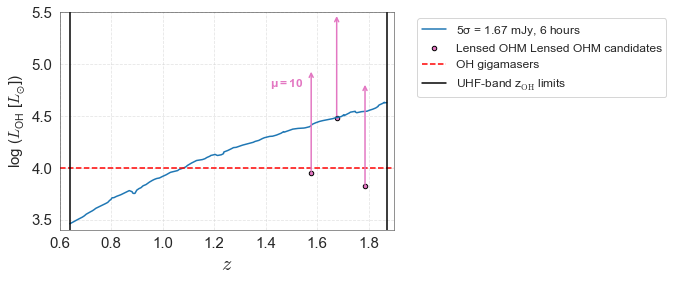

In [8]:
L_min_6hr, S_min_6hr = f_lim(z_OH, SEFD = sefd_interp(Observed_freq(z_OH, restfreq = 1667.35899).value),
                     Ncorr = 1, Npol = 2, Nant = 58, time_int = 6,
                     bandwidth= BW, sigma_level=5, restV=150, restfreq = 1667.35899)

fig, ax = plt.subplots()
ax.plot(z_OH, L_min_6hr, color='tab:blue',
        label='5$\sigma$ = %.2f $m$Jy, 6 hours'%(np.median(S_min_6hr.value)*1e3))

ax.scatter(x = Lensed_z, y = LOH_predict, s=20, alpha=1, edgecolors="k",
           color='tab:pink', label= 'Lensed OHM Lensed OHM candidates')

for i in range(len(Lensed_z)):
    ax.annotate('', xy=(Lensed_z[i], LOH_predict[i]+np.log10(10)), xytext=(Lensed_z[i], LOH_predict[i]),
                arrowprops=dict(facecolor='tab:pink', edgecolor='tab:pink', arrowstyle='->',  lw=1.5))
ax.text(Lensed_z[2]-0.26, LOH_predict[2] + 0.3, '$\mu = 10$', color='tab:pink', fontsize=12, fontweight='bold')

ax.axhline(4, xmin = 0, xmax = z_OH.max(), linestyle='dashed',
           color = 'red', label='OH gigamasers')# OH gigamasers
ax.axvline(1.87, ymin = 0, ymax = L_min_6hr.max(), linestyle='solid', color = 'black',
           label = r'UHF-band $z_{\rm OH}$ limits')#Limits of UHF band
ax.axvline(0.64, ymin = 0, ymax = L_min_6hr.max(),linestyle='solid', color = 'black')  #Limits of UHF band


ax.set_xlabel(r'$\mathit{z}$', fontsize=20)
ax.set_ylabel(r'log ($\mathit{L}_{OH}$ [$\mathit{L}_{\odot}$])')
ax.grid(True, linestyle='--', alpha=0.5)


ax.set_xlim(0.6, 1.90)
ax.set_ylim(bottom=None, top=5.5)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0))

plt.savefig('ThisWork_LOHvs_redshift_Lensed_OHMs_predictions.png', dpi = 500, bbox_inches='tight')

In [9]:
HELPdata = pd.read_csv('All_HELP_fields_spire500mircron_greater_15mJy_ULIRGs.csv')
HELPdata.head()

,field,help_id,ra,dec,redshift,zspec,f_spire_500,ferr_spire_500,cigale_dustlumin,cigale_dustlumin_err,f_pacs_green,ferr_pacs_green,logIRLum_solar,logOHLum_solar
0,ELAIS-N1,HELP_J162245.996+544311.255,245.691651,54.719793,0.5097,0.503763,22014.263,13045.737,2.015413e+38,1.007706e+37,17449.240,17186.530,11.721392,2.589799
1,ELAIS-N1,HELP_J162147.779+543921.855,245.449079,54.656071,0.0690,0.054822,75500.690,5269.664,4.262730e+37,2.131365e+36,679868.200,20179.750,11.046716,1.523811
2,ELAIS-N1,HELP_J162407.637+550438.666,246.031821,55.077407,1.3059,0.593768,24497.038,4366.221,2.196096e+38,1.098048e+37,11204.162,12382.480,11.758679,2.648713
3,ELAIS-N1,HELP_J162351.566+551235.889,245.964858,55.209969,0.8101,2.537840,28143.394,6636.190,2.748301e+38,3.012867e+37,16455.025,15548.508,11.856092,2.802626
4,ELAIS-N1,HELP_J162226.921+552941.867,245.612171,55.494963,0.6190,0.734044,22838.453,4542.591,3.320022e+38,1.660011e+37,28389.377,18566.650,11.938169,2.932307


#### Sensitivity calculations for sources with zspec, since these  sources will be easier to nevigate within the data cubes

In [10]:
z_OH = np.linspace (HELPdata['zspec'].min(), HELPdata['zspec'].max(), 3000)

L_min8hr, S_min8hr = f_lim(z_OH, SEFD = sefd_interp(Observed_freq(z_OH, restfreq = 1667.35899).value), Ncorr = 1, 
                           Npol = 2, Nant = 58, time_int = 8, bandwidth=BW, sigma_level=5,
                           restV=150, restfreq = 1667.35899)

L_min1_5hr, S_min1_5hr = f_lim(z_OH, SEFD =  sefd_interp(Observed_freq(z_OH, restfreq = 1667.35899).value),
                               Ncorr = 1, Npol = 2, Nant = 58, time_int = 1.5, bandwidth=BW, sigma_level=5,
                               restV=150, restfreq = 1667.35899)

L_min1_5hr, z_OH1_5hr , L_min8hr, z_OH8hr = L_min1_5hr[L_min1_5hr >=0], z_OH[L_min1_5hr >=0],L_min8hr[L_min8hr >=0], z_OH[L_min8hr >=0]

## Selecting candidates sources above a certain sigma level

intterp1_5hr = np.interp(HELPdata['zspec'], z_OH1_5hr, L_min1_5hr)
intterp8hr = np.interp(HELPdata['zspec'], z_OH8hr, L_min8hr)

HELPdata_1_5hr = HELPdata.query('logOHLum_solar > @intterp1_5hr')
HELPdata_8hr = HELPdata.query('logOHLum_solar > @intterp8hr')




/Users/thato/Library/CloudStorage/OneDrive-UniversityofPretoria/PhD/Codes/OH_project/tools/Predictions.py:40: RuntimeWarning: divide by zero encountered in log10
  return np.log10(Lmin.to(u.Lsun).value), sigma_level * Smin.to(u.Jy)


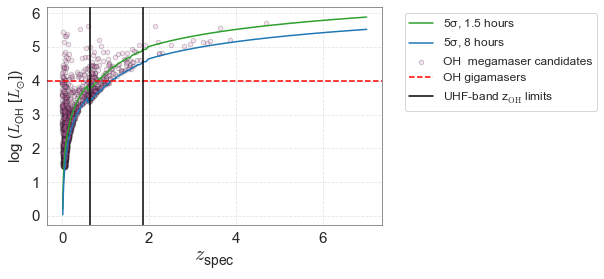

In [11]:
fig, ax = plt.subplots()
ax.plot(z_OH1_5hr, L_min1_5hr,'-', color='tab:green', 
        label='5$\sigma$, 1.5 hours')
ax.plot(z_OH8hr, L_min8hr,'-', color='tab:blue', 
        label='5$\sigma$, 8 hours')

ax.scatter(x = HELPdata_8hr['zspec'], y = HELPdata_8hr['logOHLum_solar'], 
           s=20, alpha=0.2, edgecolors="k", color='tab:pink', label= 'OH  megamaser candidates')

ax.axhline(4, xmin = 0, xmax = HELPdata_8hr['logOHLum_solar'].max(), linestyle='dashed', color = 'red',
           label='OH gigamasers')# OH gigamasers

ax.axvline(1.87, ymin = 0, ymax = L_min.max(), linestyle='solid', color = 'black',
           label = r'UHF-band $z_{\rm OH}$ limits')#Limits of UHF band
ax.axvline(0.64, ymin = 0, ymax = L_min.max(),linestyle='solid', color = 'black')  #Limits of UHF band


ax.set_xlabel('$\mathit{z}_{spec}$', fontsize=20)
ax.set_ylabel(r'log ($\mathit{L}_{OH}$ [$\mathit{L}_{\odot}$])')
ax.grid(True, linestyle='--', alpha=0.5)


plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0))

plt.savefig('ThisWork_LOHvs_redshift_realdata_zspecOnly.png', dpi = 500, bbox_inches='tight')

In [12]:
round((np.median(S_min8hr.value)*1e3)/3,3)

0.71

In [13]:
# Sources within MeerKAT's UHF-band z-limit
df = HELPdata_8hr.query('zspec >= 0.64 and zspec <= 1.87')

df['OHFlux_pred_Jy'] =  (OHflux(df['logOHLum_solar'].values, df['zspec'].values, bandwidth = BW)).value
df['SNR_8hr'] = (10**(df['logOHLum_solar']))/((10**(np.interp(df['zspec'], z_OH8hr, L_min8hr)))/5)


sorted_df =df.sort_values(by=['logIRLum_solar'], ascending=False)

sorted_df.to_csv('OHMs_catalogue_zspecMeerKATObservableUHFzlimit.csv', index = False)

/var/folders/n_/j52ffk6j49j5z8f6m87mndq40000gn/T/ipykernel_64303/2849022032.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OHFlux_pred_Jy'] =  (OHflux(df['logOHLum_solar'].values, df['zspec'].values, bandwidth = BW)).value
/var/folders/n_/j52ffk6j49j5z8f6m87mndq40000gn/T/ipykernel_64303/2849022032.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SNR_8hr'] = (10**(df['logOHLum_solar']))/((10**(np.interp(df['zspec'], z_OH8hr, L_min8hr)))/5)


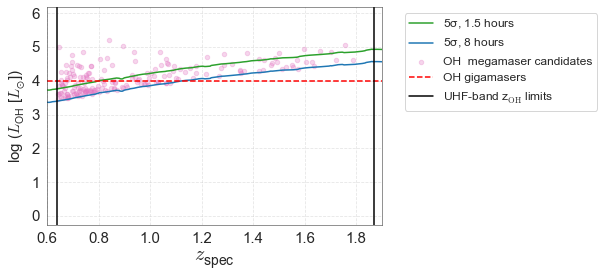

In [14]:
fig, ax = plt.subplots()
ax.plot(z_OH1_5hr, L_min1_5hr,'-', color='tab:green', 
        label='5$\sigma$, 1.5 hours')
ax.plot(z_OH8hr, L_min8hr,'-', color='tab:blue', 
        label='5$\sigma$, 8 hours')


ax.scatter(x = sorted_df['zspec'], y = sorted_df['logOHLum_solar'], 
           s=20, alpha=0.3, color='tab:pink', label= 'OH  megamaser candidates')

ax.axhline(4, xmin = 0, xmax = sorted_df['logOHLum_solar'].max(), linestyle='dashed', color = 'red',
           label='OH gigamasers')# OH gigamasers

ax.axvline(1.87, ymin = 0, ymax = L_min.max(), linestyle='solid', color = 'black',
           label =  r'UHF-band $z_{\rm OH}$ limits')#Limits of UHF band
ax.axvline(0.64, ymin = 0, ymax = L_min.max(),linestyle='solid', color = 'black')  #Limits of UHF band


ax.set_xlabel('$\mathit{z}_{spec}$', fontsize=20)
ax.set_ylabel(r'log ($\mathit{L}_{OH}$ [$\mathit{L}_{\odot}$])')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlim(0.6, 1.90)

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0))

plt.savefig('ThisWork_LOHvs_redshift_realdata_UHFlimit.png', dpi = 500, bbox_inches='tight')

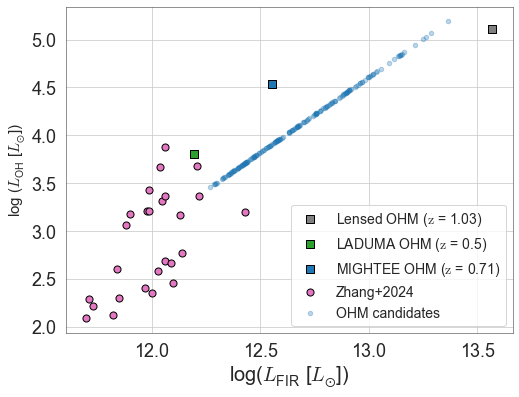

In [29]:
fashi_data = pd.read_csv('FASHI_OH_detections.csv',index_col=[0])

plt.figure(figsize=(8, 6))

# Other plot elements remain the same
plt.scatter(x=13.57, y=5.11, label=r'Lensed OHM ($\mathrm{z}$ = 1.03)',
            s=80, edgecolors="k", color='gray', marker='s')

plt.scatter(x=np.log10(1.576e12), y=np.log10(6.31e3), label=r'LADUMA OHM ($\mathrm{z}$ = 0.5)',
           s=50, edgecolors="k", color='tab:green', marker='s')

plt.scatter(x=np.log10(3.6e12), y=4.54, label=r'MIGHTEE OHM ($\mathrm{z}$ = 0.71)',
           s=50, edgecolors="k", color='tab:blue', marker='s')


plt.scatter(x=fashi_data['logLFIR'], y=fashi_data['logLOH'],
            label='Zhang+2024', s=50, edgecolors="k", color='tab:pink')

plt.scatter(x = sorted_df['logIRLum_solar'], y = sorted_df['logOHLum_solar'], 
           s=20, alpha=0.3, label= 'OHM candidates')


plt.xlabel(r"log($\mathit{L}_{FIR}$ [$\mathit{L}_{\odot}$])",fontsize = 20)
plt.ylabel(r'log ($\mathit{L}_{OH}$ [$\mathit{L}_{\odot}$])')
plt.legend(fontsize=14)
plt.tick_params(which="both", size=6, labelsize=18)


plt.savefig('LOH_vsLFIR-H1429-0028.png', dpi=500)


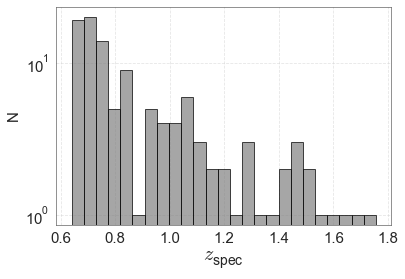

In [14]:
plt.figure()
plt.hist(sorted_df['zspec'], bins=25, color='gray', edgecolor='black', alpha=0.7)
plt.xlabel('$\mathit{z}_{spec}$', fontsize=20)
plt.ylabel('N')
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('ThisWork_redshift_distribution_zspecOnly.png', dpi=500, bbox_inches='tight')


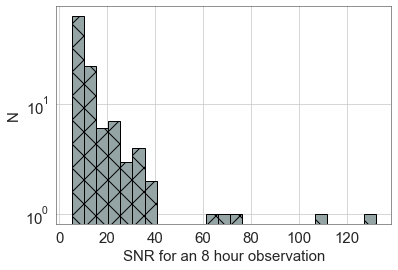

In [15]:
plt.figure()
plt.hist(sorted_df['SNR_8hr'], color='#95a5a6', bins=25, edgecolor='k', hatch ='x')
plt.ylabel('N')
plt.xlabel('SNR for an 8 hour observation')
plt.yscale('log')
plt.savefig('ThisWork_SNR.png', dpi = 500, bbox_inches='tight')

In [16]:
def exposure_time(SNR, SEFD, flux, bandwidth = BW):
    """
    Function predicts each source's time required for detection
    """

    return ((SNR**2)*(SEFD*u.Jy**2))/((flux*u.Jy**2)*(bandwidth*u.kHz))


In [17]:
Exposure_time = exposure_time(sorted_df['SNR_8hr'].values,
                            sefd_interp(Observed_freq(sorted_df['zspec'].values, restfreq = 1667.35899).value),
                              sorted_df['OHFlux_pred_Jy'].values, bandwidth = BW).to(u.hour)

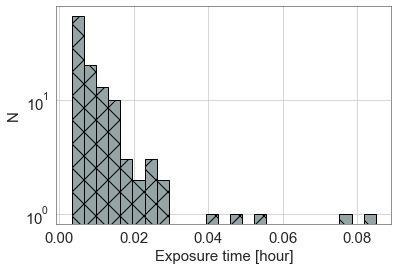

In [18]:
plt.figure()
plt.hist(Exposure_time.value, color='#95a5a6', bins=25, edgecolor='k', hatch ='x')
plt.yscale('log')
plt.ylabel('N')
plt.xlabel('Exposure time [hour]')
plt.savefig('ThisWork_Exposuretime.png', dpi = 500, bbox_inches='tight')

#### Number of OH candidates vs SNR threshold within the UHF-band redshift-limits

In [ ]:
NOH_candidates = []

for i in range(10, 110, 10):
    z_OH = np.linspace (HELPdata['zspec'].min(), HELPdata['zspec'].max(), 3000)

    L_min8hr, S_min8hr = f_lim(z_OH, SEFD = sefd_interp(Observed_freq(z_OH, restfreq = 1667.35899).value), 
                               Ncorr = 1, Npol = 2, Nant = 64, time_int = 8, bandwidth= BW, sigma_level=i,
                               restV=150, restfreq = 1667)


    L_min8hr, z_OH8hr = L_min8hr[L_min8hr >=0], z_OH[L_min8hr >=0]

    ## Selecting candidates sources above a certain sigma level
    
    intterp1_5hr = np.interp(HELPdata['zspec'], z_OH1_5hr, L_min1_5hr)
    intterp8hr = np.interp(HELPdata['zspec'], z_OH8hr, L_min8hr)

    HELPdata_1_5hr = HELPdata.query('logOHLum_solar > @intterp1_5hr')
    HELPdata_8hr = HELPdata.query('logOHLum_solar > @intterp8hr')

    df_ = HELPdata_8hr.query('zspec >= 0.64 and zspec <= 1.87')
    
    df_['OHFlux_pred_Jy'] =  (OHflux(df_['logOHLum_solar'].values, df_['zspec'].values, bandwidth = BW)).value
    df_['SNR_8hr'] = (10**(df_['logOHLum_solar']))/((10**(np.interp(df_['zspec'], z_OH8hr, L_min8hr)))/i)
    
    sorted_df_ =df_.sort_values(by=['logIRLum_solar'], ascending=False)

    sorted_df_.to_csv('OHMs_catalogue_zspecMeerKATObservableUHFzlimit-SNRThreshold%s.csv'%i, index = False)
    
    NOH_candidates.append(sorted_df_['zspec'].size)


/Users/thato/Library/CloudStorage/OneDrive-UniversityofPretoria/PhD/Codes/OH_project/tools/Predictions.py:40: RuntimeWarning: divide by zero encountered in log10
  return np.log10(Lmin.to(u.Lsun).value), sigma_level * Smin.to(u.Jy)
/var/folders/n_/j52ffk6j49j5z8f6m87mndq40000gn/T/ipykernel_97812/3761020229.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['OHFlux_pred_Jy'] =  (OHflux(df_['logOHLum_solar'].values, df_['zspec'].values, bandwidth = BW)).value
/var/folders/n_/j52ffk6j49j5z8f6m87mndq40000gn/T/ipykernel_97812/3761020229.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

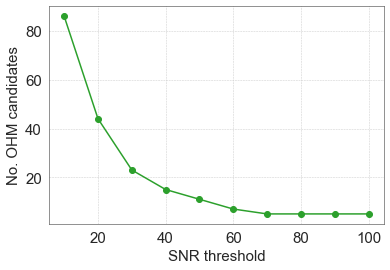

In [20]:
fig, ax = plt.subplots()
ax.plot(np.arange(10,110, 10), NOH_candidates,'o-', color='tab:green', 
        label='10$\sigma$, 1.5 hours', )

ax.set_xlabel('SNR threshold')
ax.set_ylabel('No. OHM candidates')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)


plt.savefig('ThisWork_SNRthreshold_UHFlimit.png', dpi = 500, bbox_inches='tight')

In [21]:
NOH_candidates

[86, 44, 23, 15, 11, 7, 5, 5, 5, 5]

In [21]:
dataSNR100 = pd.read_csv('OHMs_catalogue_zspecMeerKATObservableUHFzlimit-SNRThreshold100.csv')

In [22]:
def Band_ranker(z):
    """
    Function ranks whether a sources falls under MeerKATs L or UHF-band 
    """
    if (900*u.MHz < Observed_freq(z) and Observed_freq(z) < 1670*u.MHz):
        return 'L-band'
    elif (580*u.MHz < Observed_freq(z) and Observed_freq(z) < 1015*u.MHz):
        return 'UHF-band'

    else:
        return 'L/UHF-band'


In [23]:
MeerKAT_Band = []
for i in range(dataSNR100['zspec'].size):
    MeerKAT_Band.append(Band_ranker(dataSNR100['zspec'][i]))

In [24]:
dataframe_Ofinterest = dataSNR100

dataframe_Ofinterest['MeerKAT-Band'] = MeerKAT_Band

del dataframe_Ofinterest['f_spire_500']
del dataframe_Ofinterest['ferr_spire_500']
del dataframe_Ofinterest['cigale_dustlumin']
del dataframe_Ofinterest['cigale_dustlumin_err']
del dataframe_Ofinterest['f_pacs_green']
del dataframe_Ofinterest['ferr_pacs_green']

In [25]:
dataframe_Ofinterest.to_csv('Catalogue-of-interest-SNRThreshold100.csv', index = False)

In [26]:
sorted_df.size

29536

## Source density per square-degree for each field

In [27]:
def BP(obs_freq):
    """
    the FWHM of the primary power pattern at a given
    wavelength for MeerKAT, where obs_freq is the
    central frequency of the image given in GHz
    """
    return 57.5 * ((obs_freq * u.GHz) / (1.5 * u.GHz))**(-1)

a = (BP(obs_freq=0.816)*u.arcmin).to(u.degree) # the Beam at the centre of the UHF ~ 816 MHz
print(a)

1.7616421568627454 deg


In [28]:
HELP_fields = pd.read_csv('HELP_fields_info.csv')
HELP_fields.head()

,Field,Area_sq_deg,centre_RA,centre_Dec,RA_min,RA_max,Dec_min,Dec_max
0,COSMOS,5.1,150.1,2.218,148.7,151.55,0.791,3.641
1,GAMA-15,61.7,217.6,0.456,210.0,225.20,-2.530,3.433
2,XMM-LSS,21.8,35.1,-4.528,32.2,38.10,-7.454,-1.591
3,Boötes,11.4,218.1,34.173,215.7,220.60,32.191,36.109
4,CDFS-SWIRE,13.0,53.1,-28.235,50.8,55.40,-30.439,-25.997


In [29]:
fields_areas = HELP_fields[['Field', 'Area_sq_deg']]
fields_areas

,Field,Area_sq_deg
0,COSMOS,5.10
1,GAMA-15,61.70
2,XMM-LSS,21.80
3,Boötes,11.40
4,CDFS-SWIRE,13.00
5,ELAIS-N1,13.50
6,GAMA-12,62.70
7,GAMA-09,62.00
8,Lockman-SWIRE,22.40
9,EGS,3.60


In [30]:
print(HELP_fields['Area_sq_deg']/a) # the number of pointings

0       2.895026
1      35.024139
2      12.374817
3       6.471235
4       7.379478
5       7.663304
6      35.591791
7      35.194435
8      12.715409
9       2.043548
10      5.108870
11      5.222400
12      5.222400
13      4.200626
14    206.284800
15    100.871791
16    167.230330
17      4.938574
18      0.340591
19     62.668800
20      0.380327
21      0.153266
22      0.431416
Name: Area_sq_deg, dtype: float64


### Count the number of detections per field:

In [31]:
# Group by the 'field' column and count the number of entries for each field
field_counts = df['field'].value_counts().reset_index()
field_counts.columns = ['Field', 'Count']

# Merge field counts with field areas
merged_data = pd.merge(field_counts, fields_areas, on='Field')

# Calculate the number density
merged_data['N_density'] = merged_data['Count'] / merged_data['Area_sq_deg']

# Display the results
print(merged_data[['Field', 'Count', 'Area_sq_deg', 'N_density']])

                 Field  Count  Area_sq_deg  N_density
0   Herschel-Stripe-82    765       363.40   2.105118
1                  NGP    262       177.70   1.474395
2              GAMA-15    229        61.70   3.711507
3              GAMA-12    165        62.70   2.631579
4              XMM-LSS    141        21.80   6.467890
5              GAMA-09    135        62.00   2.177419
6             ELAIS-S1     40         9.00   4.444444
7           CDFS-SWIRE     34        13.00   2.615385
8               COSMOS     29         5.10   5.686275
9             ELAIS-N1     21        13.50   1.555556
10                xFLS     14         7.40   1.891892
11                 EGS      5         3.60   1.388889
12           AKARI-NEP      4         9.20   0.434783
13            XMM-13hr      1         0.76   1.315789
14            ELAIS-N2      1         9.20   0.108696
